In [1]:
from dotenv import load_dotenv
load_dotenv()
import os
fred_api_key = os.getenv(".env")
import fredapi as fr
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from src.config import load_config
from src.logger import logger
from src.data import Fred_Data
from sklearn.metrics import r2_score,root_mean_squared_error
config = load_config()
fred_data = Fred_Data(api_key=fred_api_key,series_ids=config['series_ids'])
fred_data = fred_data.fetch_data()
df = fred_data.get_dataframe()
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)


cuda:0


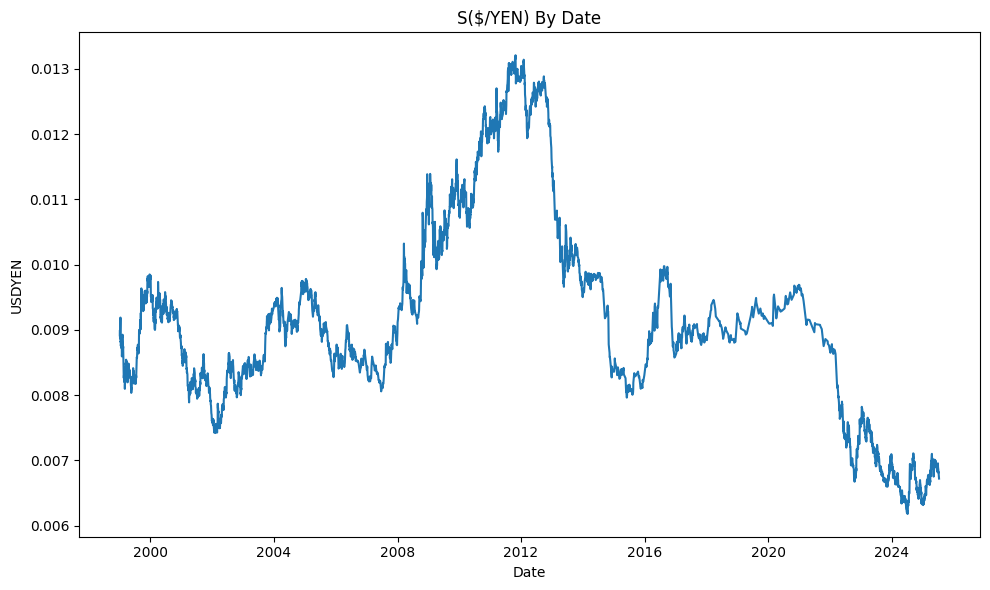

In [2]:
# changing the S(YEN/USD) to a direct quote

df['USDYEN'] = 1 / df['YENUSD']
df = df['USDYEN']
df.drop_duplicates(inplace=True)


df = df.reset_index()
df['Date'] = df['index']
df.drop('index',axis=1,inplace=True)

plt.figure(figsize=(10,6))
sns.lineplot(x='Date',y='USDYEN',data=df)
plt.title("S($/YEN) By Date")
plt.savefig("images/spotrate-USDYEN.png")
plt.tight_layout()
plt.show()




In [3]:

training = df.iloc[:,0:1].values
train_size = int(len(training) * .90)


train_data = training[:train_size]
test_data = training[train_size:]


scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)







def slider(data,seq_length):
    X,y = [],[]
    for i in range(len(data) - seq_length - 1):
        Xi = data[i:(i+seq_length)]
        yi = data[(i+seq_length)]
        X.append(Xi)
        y.append(yi)
        
    return np.array(X),np.array(y)

seq_length = 7

X_train,y_train = slider(train_scaled,seq_length)
X_test,y_test = slider(test_scaled,seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()




class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BiLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, X):
        h0 = torch.zeros(2 * self.num_layers, X.size(0), self.hidden_size)
        c0 = torch.zeros(2 * self.num_layers, X.size(0), self.hidden_size)
        out, _ = self.lstm(X,(h0,c0))
        out = self.fc(out[:,-1,:])
        return out



model = BiLSTM(input_size=1,hidden_size=128,num_layers=2,output_size=1)
epochs = 500
learning_rate = 0.001
bilistm_optimizer = torch.optim.Adam(params=model.parameters(),lr=learning_rate)
loss_fn = nn.MSELoss()


for epoch in range(epochs):
    y_pred = model(X_train)
    loss = loss_fn(y_pred.float(),y_train)
    bilistm_optimizer.zero_grad()
    loss.backward()
    bilistm_optimizer.step()
    if epoch % 1 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rsme = np.sqrt(loss_fn(y_pred,y_train))
        y_pred_test =  model(X_test)
        test_rsme = np.sqrt(loss_fn(y_pred_test,y_test))
        print(f'Epoch: {epoch}; train_RSEM: {train_rsme:.4}; Test RSME: {test_rsme:.4}')



C:\Users\katsa\AppData\Local\Temp\ipykernel_11244\3171268231.py:80: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rsme = np.sqrt(loss_fn(y_pred,y_train))
C:\Users\katsa\AppData\Local\Temp\ipykernel_11244\3171268231.py:82: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rsme = np.sqrt(loss_fn(y_pred_test,y_test))


Epoch: 0; train_RSEM: 0.4512; Test RSME: 0.05044
Epoch: 1; train_RSEM: 0.4073; Test RSME: 0.0914
Epoch: 2; train_RSEM: 0.3607; Test RSME: 0.1417
Epoch: 3; train_RSEM: 0.3109; Test RSME: 0.2008
Epoch: 4; train_RSEM: 0.2606; Test RSME: 0.2712
Epoch: 5; train_RSEM: 0.2218; Test RSME: 0.3561
Epoch: 6; train_RSEM: 0.2235; Test RSME: 0.4538
Epoch: 7; train_RSEM: 0.261; Test RSME: 0.5289
Epoch: 8; train_RSEM: 0.2712; Test RSME: 0.5415
Epoch: 9; train_RSEM: 0.2531; Test RSME: 0.5135
Epoch: 10; train_RSEM: 0.2271; Test RSME: 0.4683
Epoch: 11; train_RSEM: 0.2082; Test RSME: 0.4202
Epoch: 12; train_RSEM: 0.2008; Test RSME: 0.377
Epoch: 13; train_RSEM: 0.2019; Test RSME: 0.3416
Epoch: 14; train_RSEM: 0.2062; Test RSME: 0.3147
Epoch: 15; train_RSEM: 0.2098; Test RSME: 0.2956
Epoch: 16; train_RSEM: 0.2108; Test RSME: 0.2836
Epoch: 17; train_RSEM: 0.2084; Test RSME: 0.2777
Epoch: 18; train_RSEM: 0.2027; Test RSME: 0.2771
Epoch: 19; train_RSEM: 0.1943; Test RSME: 0.281
Epoch: 20; train_RSEM: 0.1839; T

In [6]:
with torch.no_grad():
    pred = model(X_test)
    pred_np = pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    pred_rescaled = scaler.inverse_transform(pred_np)
    actual_rescaled = scaler.inverse_transform(y_test_np)

rmse = root_mean_squared_error(y_test_np,pred_np)
r2 = r2_score(y_test,pred_np)
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f'R2 Score: {r2*100:.2f}%')

test_dates = df.iloc[train_size + seq_length: -1]['Date'].reset_index(drop=True)

comparison_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Spot Rate": actual_rescaled.flatten(),
    "Predicted Spot Rate": pred_rescaled.flatten()
})

print(comparison_df.head(20))
print(comparison_df.tail(20))

Root Mean Squared Error: 0.0101
R2 Score: 91.42%
         Date  Actual Spot Rate  Predicted Spot Rate
0  2023-10-20          0.006673             0.006679
1  2023-10-23          0.006676             0.006675
2  2023-10-24          0.006674             0.006674
3  2023-10-25          0.006669             0.006673
4  2023-10-26          0.006647             0.006671
5  2023-10-27          0.006684             0.006663
6  2023-10-30          0.006711             0.006669
7  2023-10-31          0.006602             0.006680
8  2023-11-01          0.006624             0.006657
9  2023-11-02          0.006645             0.006648
10 2023-11-03          0.006695             0.006646
11 2023-11-07          0.006646             0.006658
12 2023-11-08          0.006633             0.006653
13 2023-11-09          0.006621             0.006646
14 2023-11-13          0.006598             0.006636
15 2023-11-14          0.006633             0.006626
16 2023-11-15          0.006619             0.0066

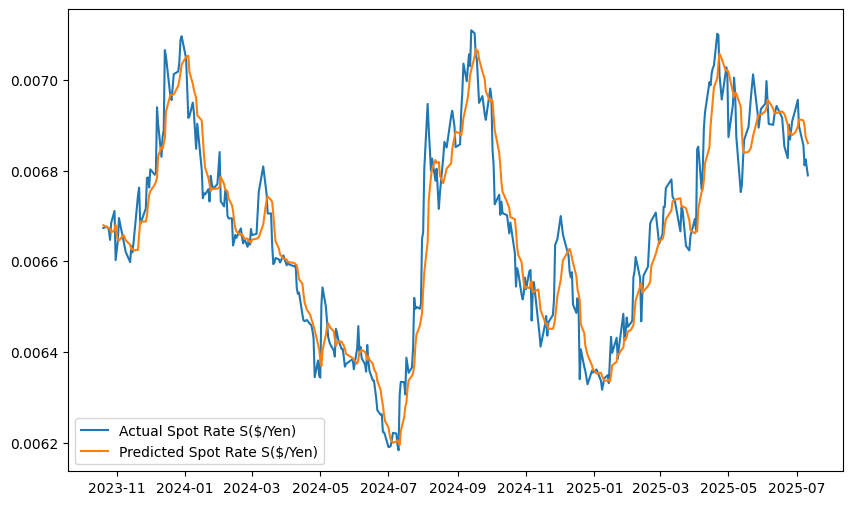

In [7]:
plt.figure(figsize=(10,6))
plt.plot(comparison_df['Date'],comparison_df["Actual Spot Rate"],label="Actual Spot Rate S($/Yen)")
plt.plot(comparison_df['Date'],comparison_df['Predicted Spot Rate'],label="Predicted Spot Rate S($/Yen)")
plt.legend()
plt.savefig("images/predicted_vs_actual_SpotRate-usdyen.png")
plt.show()